In [10]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        
    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    
    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True):
        super(ConvLSTM, self).__init__()
        
        self._check_kernel_size_consistency(kernel_size)
        
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        
        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))
        
        self.cell_list = nn.ModuleList(cell_list)
        
        # Nueva capa de convolución para reducir a un solo canal de salida
        self.conv_out = nn.Conv2d(hidden_dim[-1], 1, kernel_size=1)
        
    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        
        b, _, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        cur_layer_input = input_tensor
        
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(input_tensor.size(1)):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)
            
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

        # Tomamos la salida de la última capa y del último paso temporal
        last_output = cur_layer_input[:, -1, :, :, :]  # (batch, hidden_dim[-1], H, W)
        
        # Aplicamos la convolución para reducir la salida a un solo canal
        output = self.conv_out(last_output)  # (batch, 1, H, W)
        
        return output
    
    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states
    
    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')
    
    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [3]:

# ===================
# Cargar y Organizar los Datos
# ===================

# Ruta donde están los archivos
data_dir = 'data/tmean_interp_final/npy'

# Obtener la lista de archivos .npy en orden temporal
file_list = sorted(glob(os.path.join(data_dir, 'temperatura_*.npy')))

# Cargar todos los archivos y convertirlos en un solo tensor
data_list = [np.load(file) for file in file_list]  # Cada archivo debe ser de tamaño (271, 221)
data = np.stack(data_list)  # Forma resultante: (T, H, W), donde T es el total de meses
data = torch.tensor(data, dtype=torch.float32)  # Convertir a tensor de PyTorch

# ===================
# Preparar los Datos para el Dataset
# ===================

class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], self.data[idx+self.seq_length])

# Parámetros del modelo y de entrenamiento
seq_length = 12  # Usaremos 12 meses para predecir el siguiente
train_size = int(0.8 * len(data))  # División 80% para entrenamiento
train_data, test_data = data[:train_size], data[train_size:]

train_dataset = TemperatureDataset(train_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# ===================
# Configuración del modelo
# ===================

input_dim = 1  # Un canal de temperatura
hidden_dim = [64, 64]
kernel_size = (3,3)
num_layers = 2

model = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, batch_first=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===================
# Entrenamiento del Modelo
# ===================

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for seq, target in train_loader:
        seq = seq.unsqueeze(2)  # (batch, seq_length, 1, 271, 221)
        target = target.unsqueeze(1)  # (batch, 1, 271, 221)
        
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")



In [9]:
# ===================
# Predicción
# ===================

def predict_future(data, model, steps):
    model.eval()
    predictions = []
    input_seq = data[-seq_length:]  # Usa los últimos `seq_length` pasos de tiempo, con forma (seq_length, 271, 221)
    
    for _ in range(steps):
        # Añadimos las dimensiones de batch y canal
        input_seq_tensor = input_seq.unsqueeze(0).unsqueeze(2)  # (1, seq_length, 1, 271, 221)
        
        with torch.no_grad():
            output = model(input_seq_tensor)  # Salida de forma (1, 1, 271, 221)
            next_pred = output.squeeze(0).squeeze(0)  # Redimensionamos a (271, 221)
        
        predictions.append(next_pred)
        
        # Ajustamos next_pred para que tenga la misma dimensión que input_seq[1:]
        next_pred = next_pred.unsqueeze(0)  # (1, 271, 221)
        input_seq = torch.cat((input_seq[1:], next_pred), dim=0)  # Concatenar en la dimensión de tiempo (0)

    return torch.stack(predictions)


# Predicción para los siguientes 6 meses
num_future_months = 6
future_predictions = predict_future(test_data, model, num_future_months)

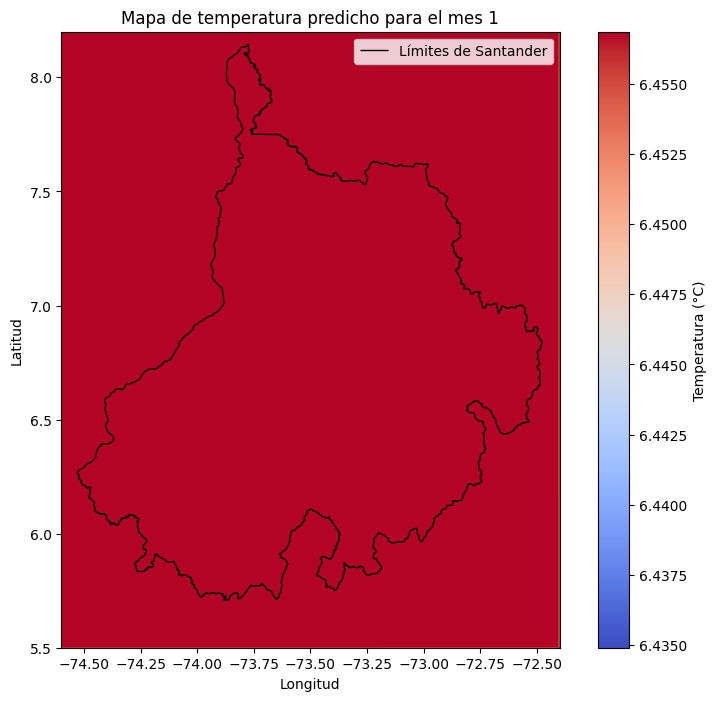

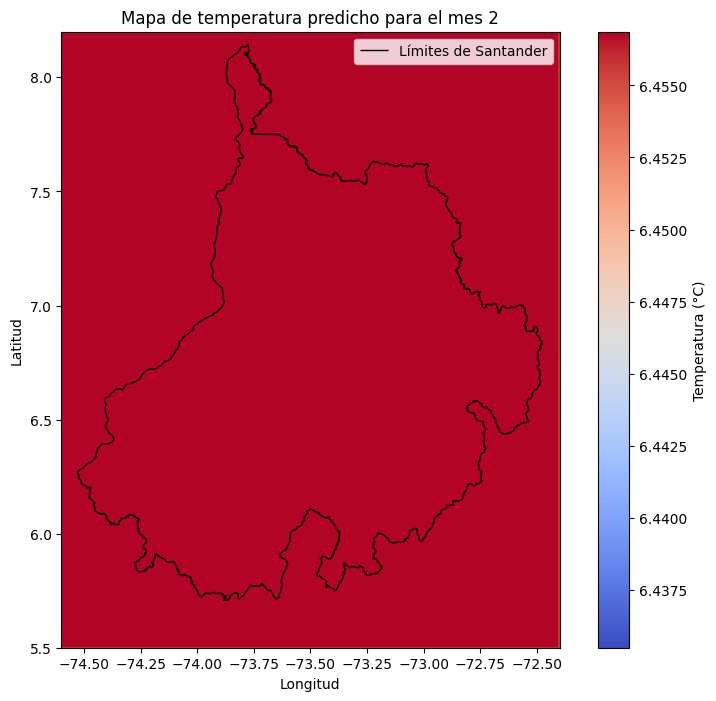

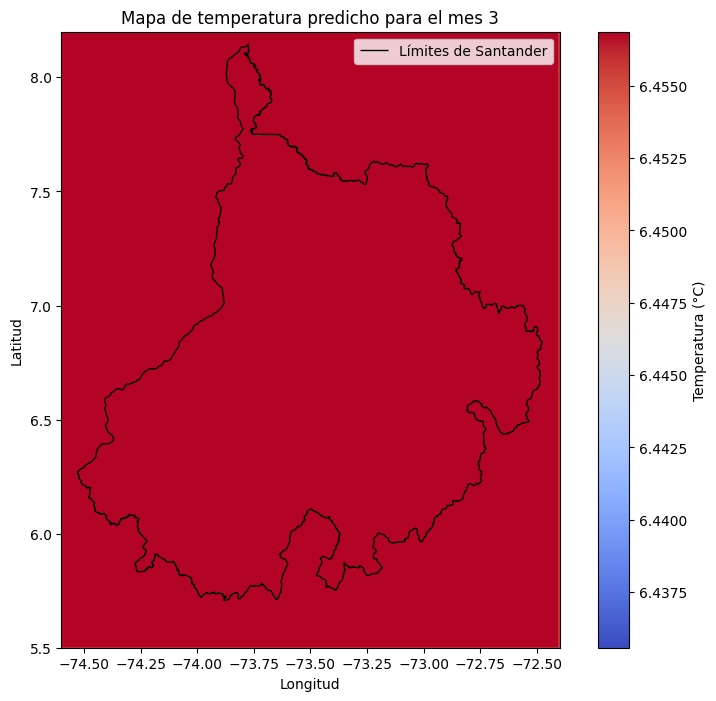

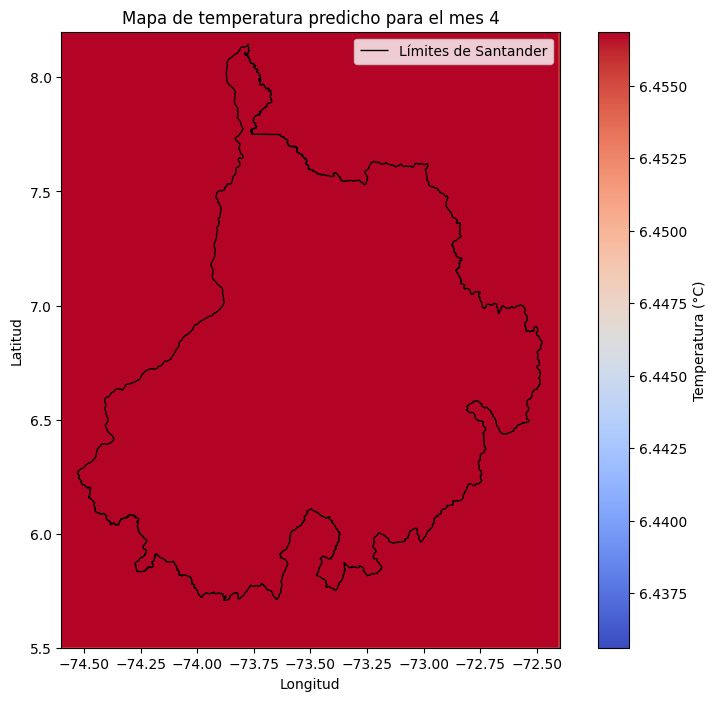

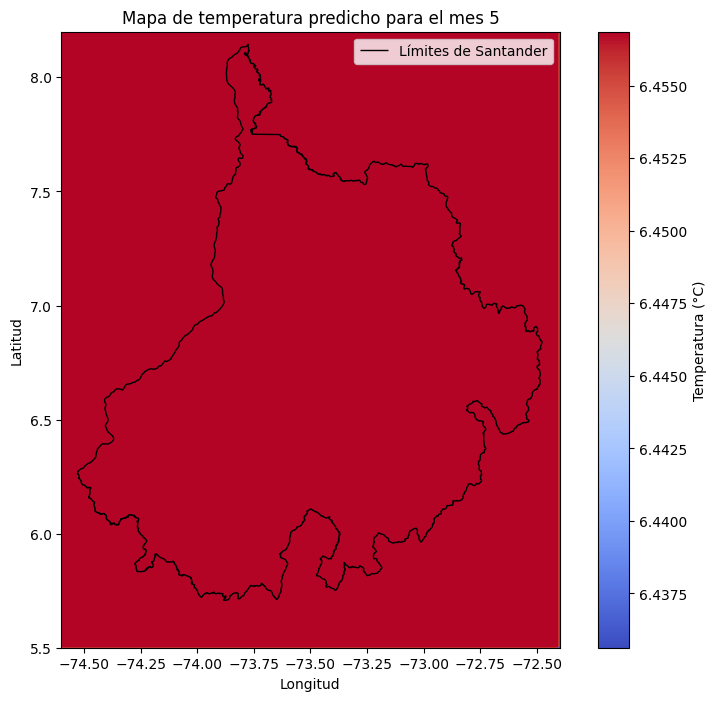

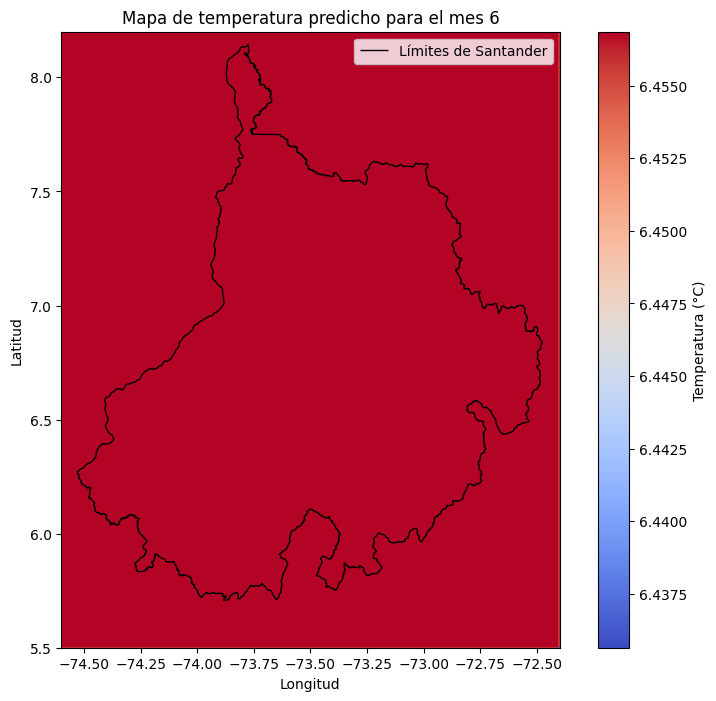

In [11]:
# Definir la región para limitar el gráfico
region = (-74.6, -72.4, 5.5, 8.2)

# Cargar el shapefile de los límites administrativos de Colombia
colombia_shapefile = 'data/aoi/Departamento.shp'
gdf = gpd.read_file(colombia_shapefile)

# Reproyectar a WGS84 si es necesario
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Filtrar para el departamento de Santander
santander_gdf = gdf[gdf['DeNombre'] == 'Santander']

# Crear las coordenadas de latitud y longitud para la grilla
latitudes = np.linspace(region[2], region[3], 271)
longitudes = np.linspace(region[0], region[1], 221)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Iterar sobre cada mes predicho en `future_predictions`
for i, pred in enumerate(future_predictions):
    # Convertir la predicción del mes actual a numpy
    temperature_map = pred.numpy()  # Tiene forma (271, 221)

    # Graficar la predicción de temperatura
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(lon_grid, lat_grid, temperature_map, cmap='coolwarm', shading='auto')
    plt.colorbar(label='Temperatura (°C)')

    # Superponer los límites administrativos de Santander
    santander_gdf.boundary.plot(ax=plt.gca(), linewidth=1, edgecolor="black", label="Límites de Santander")

    # Limitar los ejes al área de interés
    plt.xlim(region[0], region[1])
    plt.ylim(region[2], region[3])

    # Etiquetas y título
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title(f'Mapa de temperatura predicho para el mes {i + 1}')
    plt.legend()
    plt.show()
